In [87]:
# import the modules we need. 

import ase
from pymatgen import Structure
from ase.io import read, write
from ase import Atoms
from icet import (ClusterSpace, StructureContainer,
                  CrossValidationEstimator, ClusterExpansion)
from pymatgen.io.ase import AseAtomsAdaptor
from tqdm import tqdm
from icet.tools.structure_generation import occupy_structure_randomly

from ase import Atom
from ase.build import bulk
from icet import ClusterSpace
from icet.tools.structure_generation import *

import json


from polyhedral_analysis.configuration import Configuration
from polyhedral_analysis.octahedral_analysis import *
from polyhedral_analysis.polyhedra_recipe import PolyhedraRecipe


import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["mathtext.fontset"] ='custom'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica'
plt.rcParams["font.size"] = "8"
plt.rcParams['axes.linewidth'] = 0.75
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 4

! ls

LNMO_SQS.cif
LNMO_disordered_O_vac_1.json
LNMO_disordered_O_vac_2.json
LNMO_disordered_O_vac_3.json
LNMO_disordered_pristine.json
LNMO_pristine_from_CE_MC.cif
O2.json
data.dat
data_disordered.dat
test.png
wrong_pos_FIG_4_O_environments_O_vacancy_formation_energies.ipynb


In [88]:
sqs = read('LNMO_SQS.cif')
sqs = AseAtomsAdaptor.get_structure(sqs)

# Note that the 'pristine model' contains Na in the Li layer
pristine = read('LNMO_pristine_from_CE_MC.cif')
pristine = AseAtomsAdaptor.get_structure(pristine)

# Note that to obtain the pristine model, the cluster expansion uses Na as a dummy atom 
# in the Li layer (to prevent mixing between Li in the TM layer and Li in the Li layer)
# so to get the correct environments in this 
pristine['Na'] = 'Li'
print(pristine)

Full Formula (Li2016 Mn1152 Ni288 O3456)
Reduced Formula: Li7Mn4NiO12
abc   :  68.229599  68.229599  14.145600
angles:  90.000000  90.000000 120.000000
Sites (6912)
   #  SP           a        b        c
----  ----  --------  -------  -------
   0  Li     0        0        0
   1  Li     0.02778  0.01389  0.33333
   2  Li     0.01389  0.02778  0.66667
   3  O      0        0        0.23959
   4  O      0.02778  0.01389  0.09375
   5  O      0.02778  0.01389  0.57292
   6  O      0.01389  0.02778  0.42708
   7  O      0.01389  0.02778  0.90625
   8  O      0        0        0.76041
   9  Mn     0.01389  0.02778  0.16667
  10  Ni     0        0        0.5
  11  Ni     0.02778  0.01389  0.83333
  12  Li    -0        0.04167  0
  13  Li     0.02778  0.05556  0.33333
  14  Li     0.01389  0.06944  0.66667
  15  O     -0        0.04167  0.23959
  16  O      0.02778  0.05556  0.09375
  17  O      0.02778  0.05556  0.57292
  18  O      0.01389  0.06944  0.42708
  19  O      0.01389  0.06944  0

In [89]:
recipe_O = PolyhedraRecipe( method='distance cutoff', 
                          coordination_cutoff=2.5, 
                          central_atoms='O',
                          vertex_atoms=['Li','Mn','Ni'])

In [90]:
def get_envs(structure):
    #structure = AseAtomsAdaptor.get_structure(structure)
    config_O = Configuration( structure=structure, recipes=[recipe_O] )

    O_Li6 = []
    O_Li5 = []
    O_Li4 = []
    O_Li3 = []
    O_Li2 = []
    O_Li1 = []
    O_Li0 = []

    for p in config_O.polyhedra:
        if   p.vertex_labels.count('Li') == 6:
            O_Li6.append(p)
        elif p.vertex_labels.count('Li') == 5:
            O_Li5.append(p)
        elif p.vertex_labels.count('Li') == 4:
            O_Li4.append(p)
        elif p.vertex_labels.count('Li') == 3:
            O_Li3.append(p)
        elif p.vertex_labels.count('Li') == 2:
            O_Li2.append(p)
        elif p.vertex_labels.count('Li') == 1:
            O_Li1.append(p)
        elif p.vertex_labels.count('Li') == 0:
            O_Li0.append(p)

            
    total = len(config_O.polyhedra)
    print(total)

    frac_O_Li6 = len(O_Li6) / total * 100
    frac_O_Li5 = len(O_Li5) / total * 100
    frac_O_Li4 = len(O_Li4) / total * 100
    frac_O_Li3 = len(O_Li3) / total * 100
    frac_O_Li2 = len(O_Li2) / total * 100
    frac_O_Li1 = len(O_Li1) / total * 100
    frac_O_Li0 = len(O_Li0) / total * 100
    
    sites_list = [frac_O_Li6, frac_O_Li5, frac_O_Li4, frac_O_Li3, 
              frac_O_Li2, frac_O_Li1, frac_O_Li0 ]
    
    return sites_list

sites_list  = get_envs(sqs)
p_sites_list  = get_envs(pristine)

48
3456


In [91]:
# Reminder - need to label the origin of 'data disordered' and 'data'

import numpy as np
from numpy import genfromtxt
data = (genfromtxt('data.dat'))
data_disordered = (genfromtxt('data_disordered.dat'))
print(data_disordered)


[[ 4.     4.7  ]
 [ 4.     4.2  ]
 [ 4.     3.8  ]
 [ 4.     4.35 ]
 [ 1.     0.225]
 [ 1.     0.195]
 [ 0.    -4.222]]


In [92]:
pristine = {'struc':[], 'E': [], 'comp':[], 'vol':[]}
O2 = {'struc':[], 'E': [], 'comp':[]}
O_vac_1 = {'struc':[], 'E': [], 'comp':[], 'O_vac_form_E':[], 'vol':[]}
O_vac_2 = {'struc':[], 'E': [], 'comp':[], 'O_vac_form_E':[], 'vol':[]}
O_vac_3 = {'struc':[], 'E': [], 'comp':[], 'O_vac_form_E':[], 'vol':[]}

path = './'
def get_json(filename, results):

    with open(f'{path}/{filename}.json') as data:
            cluster_data = json.load(data)
    for n, calculation in enumerate(cluster_data['calculation_results']):
        atoms = ase.Atoms(numbers=calculation['structure']['numbers'],
                          positions=calculation['structure']['positions'],
                          pbc=calculation['structure']['pbc'],
                          cell=calculation['structure']['cell'])
        numbers = atoms.numbers
        epfu = float(calculation['energy']) *27.2114
        x_O = ( np.count_nonzero(numbers == 8) / 48 ) 
        results['E'].append(epfu)
        results['comp'].append(x_O)
        results['struc'].append(atoms)

get_json('LNMO_disordered_pristine',pristine)
get_json('LNMO_disordered_O_vac_1',O_vac_1)
get_json('LNMO_disordered_O_vac_2',O_vac_2)
get_json('LNMO_disordered_O_vac_3',O_vac_3)
get_json('O2',O2)


In [93]:
for e in O_vac_1['E']:
    O_vac_form_E = e - pristine['E'][0] + (0.5*O2['E'][0])
    print(O_vac_form_E)
    O_vac_1['O_vac_form_E'].append(O_vac_form_E)


3.614607405672359
5.305047602216291
4.894558463069188
3.531208274243909
2.1516926091262576
3.142305666637185
2.6369320083740604
4.176477644765328
2.9009136093645793
2.094925547075036
2.2812376490892348
3.8761818863549706
2.2419261558079597
1.9886380908410501
2.541302713272671
3.122481345488268
3.817850712859581
3.656772558517332
2.594931756668302
1.3470319189927977
0.09383021207577258
4.030040584095332
3.937895980952817
3.045198248290035
4.9642016875423
-0.352668589041059
-0.4058927269088599
3.6015078378241014
2.1343012592387822
3.6052404255005968
4.030856654104355
2.8921074560475972
3.252317547272469
4.001781817465599
3.905603396180595
1.9366414591768262
2.0658926159940165
3.9549964410816756
3.051697963323022
3.821178939249876
5.318648676327939
0.4396343159587559
3.9212455973593023
2.2279408567683276
3.3938742433074367
3.3523550892114145
2.745058955215427
1.9551928311684605


In [94]:
struc = AseAtomsAdaptor.get_structure(pristine['struc'][0])
config_O = Configuration( structure=struc, recipes=[recipe_O] )
O_coord = [ 6- p.vertex_labels.count('Li') for p in config_O.polyhedra ]

In [95]:
OTM0 = []
OTM1 = []
OTM2 = []
OTM3 = []
OTM4 = []
OTM5 = []
for c, e in zip(O_coord, O_vac_1['O_vac_form_E']):
    if c == 0:
        OTM0.append(e)
    if c == 1:
        OTM1.append(e)
    if c == 2:
        OTM2.append(e)
    if c == 3:
        OTM3.append(e)
    if c == 4:
        OTM4.append(e)
    if c == 5:
        OTM5.append(e)
for c, e in zip(data_disordered[:,0], data_disordered[:,1]):
    if c == 0:
        OTM0.append(e)
    if c == 1:
        OTM1.append(e)
    if c == 2:
        OTM2.append(e)
    if c == 3:
        OTM3.append(e)
    if c == 4:
        OTM4.append(e)
    if c == 5:
        OTM5.append(e)
print(OTM0)    

[0.09383021207577258, -0.352668589041059, -0.4058927269088599, -4.222]


In [96]:
data_disordered = [OTM0, OTM1, OTM2, OTM3, OTM4, OTM5]


In [97]:
OTM0 = []
OTM1 = []
OTM2 = []
OTM3 = []
OTM4 = []
OTM5 = []
for c, e in zip(data[:,0], data[:,1]):
    if c == 0:
        OTM0.append(e)
    if c == 1:
        OTM1.append(e)
    if c == 2:
        OTM2.append(e)
    if c == 3:
        OTM3.append(e)
    if c == 4:
        OTM4.append(e)
    if c == 5:
        OTM5.append(e)
print(OTM0)    
data = [OTM0, OTM1, OTM2, OTM3, OTM4, OTM5]


[99999.0]


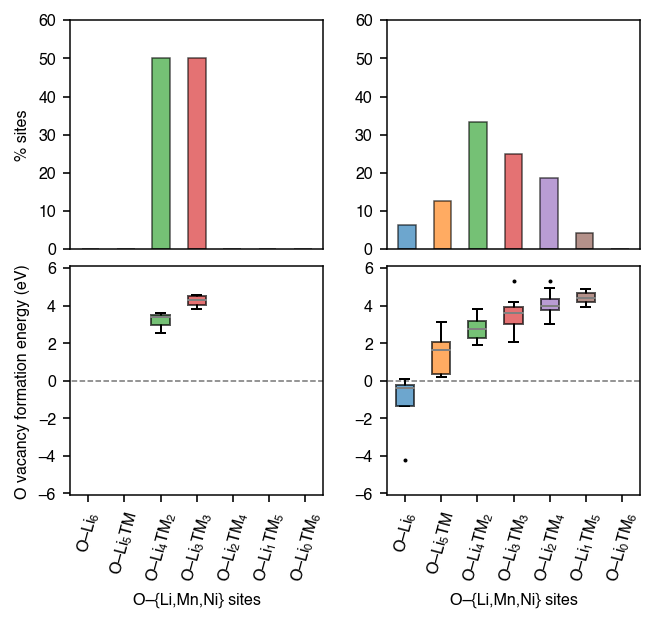

In [98]:


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(4.4, 3.3))

a = axes[0,0]
b = axes[0,1]
c = axes[1,0]
d = axes[1,1]

O_bar_colors = ['tab:blue',
              'tab:orange',
              'tab:green',
              'tab:red', 
              'tab:purple',
              'tab:brown',
              'tab:pink']

x = ['O–Li$_6$','O–Li$_5$TM',
     'O–Li$_4$TM$_2$','O–Li$_3$TM$_3$',
     'O–Li$_2$TM$_4$','O–Li$_1$TM$_5$','O–Li$_0$TM$_6$']

N= len(x)
ind = np.arange(N) 
width = 0.5
linewidth = 0.75

a.bar(ind , p_sites_list , width, color=O_bar_colors, 
      alpha=0.65, edgecolor='k', linewidth = linewidth)

b.bar(ind , sites_list , width, color=O_bar_colors, 
      alpha=0.65, edgecolor='k', linewidth = linewidth)

x1 = [-1,10]
y1 = [0,0]

colors = ['tab:blue',
              'tab:orange',
              'tab:green',
              'tab:red', 
              'tab:purple',
              'tab:brown',
              'tab:pink']
props = dict(color='black')

flierprops = dict(marker='o', markerfacecolor='grey', markersize=1,
                  linestyle='none')
medianprops = dict(linestyle='-', linewidth=1.0, color='grey')

box_1 = c.boxplot(data, flierprops=flierprops, medianprops=medianprops, patch_artist=True)
box_2 = d.boxplot(data_disordered, flierprops=flierprops, medianprops=medianprops, patch_artist=True)


for patch, color in zip(box_1['boxes'], colors):
    patch.set_edgecolor('k')
    patch.set_facecolor(color)
    patch.set_alpha(0.65)
    
for patch, color in zip(box_2['boxes'], colors):
    patch.set_edgecolor('k')
    patch.set_facecolor(color)
    patch.set_alpha(0.65)

a.set_xticklabels([])
a.set_xticks([])

a.set_ylabel('% sites')

left_axes = [a,b]
for axis in left_axes:
    axis.set_yticks([])
    axis.set_xticklabels([])    
    axis.set_xticks([])    
    axis.set_yticks([0,10,20,30,40,50, 60])

c.set_ylabel('O vacancy formation energy (eV)')

bottom_axes = [c, d]
for axis in bottom_axes:
    axis.set_xlabel('O–{Li,Mn,Ni} sites')
    axis.set_xticks([1,2,3,4,5,6,7])
    axis.set_xlim([0.5, 7.5])
    axis.set_ylim([-6.1, 6.1])
    axis.plot(x1 , y1 , '--', color='black', 
      alpha=0.55)
    axis.set_xticks(ind+1)
    axis.set_xticklabels(x, rotation = 75)

text_y_position = 53
text_y_position_2 = 55

fig.subplots_adjust(bottom=0.0, top=1.0, left=0.0, right=0.9,
                    wspace=0.25, hspace=0.075)

plt.savefig('Figure_4-oxygen_environments__oxygen_vacancy_formation_energies.png', 
            dpi=300, bbox_inches='tight')
